# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [0]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [0]:
import numpy as np
import datetime
import os, sys

In [0]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [0]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [0]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [0]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [0]:
n_noise = 100

In [11]:
!git clone https://github.com/LeChangAlex/GAN-Metric.git


fatal: destination path 'GAN-Metric' already exists and is not an empty directory.


In [0]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [13]:
G.load_state_dict(torch.load("./GAN-Metric/G.pkl"))


<All keys matched successfully>

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [0]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [0]:
batch_size = 64

In [0]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [0]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [0]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [0]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [0]:
# for epoch in range(max_epoch):
#     for idx, (images, _) in enumerate(data_loader):
#         # Training Discriminator
#         x = images.to(DEVICE)
#         x_outputs = D(x)
#         D_x_loss = criterion(x_outputs, D_labels)

#         z = torch.randn(batch_size, n_noise).to(DEVICE)
#         z_outputs = D(G(z))
#         D_z_loss = criterion(z_outputs, D_fakes)
#         D_loss = D_x_loss + D_z_loss
        
#         D.zero_grad()
#         D_loss.backward()
#         D_opt.step()

#         if step % n_critic == 0:
#             # Training Generator
#             z = torch.randn(batch_size, n_noise).to(DEVICE)
#             z_outputs = D(G(z))
#             G_loss = criterion(z_outputs, D_labels)

#             G.zero_grad()
#             G_loss.backward()
#             G_opt.step()
        
#         if step % 500 == 0:
#             print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
#         if step % 1000 == 0:
#             G.eval()
#             img = get_sample_image(G, n_noise)
#             imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
#             G.train()
#         step += 1

## Visualize Sample

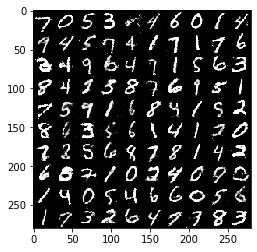

In [23]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [0]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

capacity = 64
latent_dims = 10
autoencoder = Autoencoder().to(DEVICE)


In [26]:
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/autoencoder.pth", "./pretrained/autoencoder.pth")
autoencoder.load_state_dict(torch.load('./pretrained/autoencoder.pth'))
print('done')

# this is how the autoencoder parameters can be saved:
# torch.save(autoencoder.state_dict(), './pretrained/my_autoencoder.pth')

downloading ...
done


In [0]:

# =========================


# We are only working with 256 images for each group (real/fake)
batch_size = 256

# Sample noise
z = torch.randn(batch_size, n_noise).to(DEVICE)

# Generate images
g_z = G(z)

real = torch.load("../data/MNIST/processed/training.pt")[0].type(torch.float) / (255./2) - 1

real = real.cuda().unsqueeze(1)[:batch_size, :, :, :]


In [0]:
fake_encoding = autoencoder.encoder(g_z)
real_encoding = autoencoder.encoder(real)

In [30]:



# TODO: fit a multivariate gaussian distribution for fake_encoding and real_encoding
# A MV Gaussian has 2 parameters, mu and sigma.
# See this link for the formula of FID score:
# https://medium.com/@jonathan_hui/gan-how-to-measure-gan-performance-64b988c47732
# (Use numpy's matrix functions)

import numpy as np

print(fake_encoding.shape)
print(real_encoding.shape)
# ==================================

torch.Size([256, 10])
torch.Size([256, 10])
